In [1]:
import os 
import numpy as np

from glob import glob
from utils_tbox.utils_tbox import read_pklz, write_pklz,decompress_obj
import torch
import lightning as L
from src.itgpt import ITGPT, TSdata, Predictor
from src.compx.mydata import TheDataset
from src.ITGPT.trainer import plot_confusion_matrix,lTrainer
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm 
from parse import parse
from torch.utils.data import Subset
import hashlib

def add_prefix_to_keys(in_arg, pref="",sep=":"):
    """Recursively append a prefix to all the keys in a `dict` of `dict`.
    The recursion stops when the values are not `dict`."""
    return {pref+k: add_prefix_to_keys(v, pref=pref+k+sep) if isinstance(v, dict) else v for k, v in in_arg.items()}
    # return [add_prefix_to_keys(in_arg[k], pref=pref+k+":") for k in in_arg] if isinstance(in_arg, dict)  else in_arg
    # {pref + k: in_d[k] if ~isinstance(in_d[k], dict) else  for k in in_d.keys()}

def get_leafs(d):
    """Recursively get a `list` of all the values which are not `dict` in a `dict` of `dict`.
    The recursion stops when the values are not `dict`."""
    return [get_leafs(v) if isinstance(v, dict) else {k: v} for k, v in d.items()]


def flatten_list(li):
    """Recursively flatten a `list` of `list`.
    The recursion stops when the input are not `lists`.
    """
    return sum(([x] if not isinstance(x, list) else flatten_list(x)
                for x in li), [])

def flatten_dict(ld,sep=":"):
    """flatten a `dict` of `dict`.
    e.g.
    Input:{"a":{"a1":"a11", "a2":"a12"} ,"b":"b1"}
    Output: {"a:a1":"a11","a:a2":"a12","b":"b1"}
    """
    flat_keys = add_prefix_to_keys(ld,sep=sep)
    flat_list_of_kv = flatten_list(get_leafs(flat_keys))
    flat_dict = {k: v for ll in flat_list_of_kv for k, v in ll.items()}
    return flat_dict

def gethash(s: str, salt="") -> str:
    """Use the function returned by `patdb_tbox.pn.format_pn.init_hash_fun` instead."""
    if isinstance(s, str):
        out = hashlib.sha256((salt+s).encode("utf8")).hexdigest()
    else:
        out = hashlib.sha256((salt+str(s)).encode("utf8")).hexdigest()
    return out

import copy

def inference_code(results):
    fname_ckpt = os.path.join(root_dir, results['last_checkpoint'])
    
    the_hash = gethash(fname_ckpt)
    the_cache_fname = os.path.join("cache", the_hash+".pklz")
    #if not os.path.exists(the_cache_fname):
    print("Read & score:",fname_ckpt,)
    
    #training_set = Subset(dataset, results['fold_train_index'])
    val_set_internal = Subset(dataset, results['fold_val_index'])
    loaded = torch.load(fname_ckpt)
    
    hparams = loaded["hyper_parameters"]
    
    model = Predictor(hparams["model"])
    ltrainer=lTrainer(model=model, hparams=hparams)
    plt.close("all")
    
    yclass = results['yclass']
    logits = results['logits']
    
    ltrainer.init_confmat(n=logits.shape[-1])
    keep = yclass != logits.shape[-1]
    
    scores = ltrainer.get_scores(logits, yclass)
    scores = {k: v.item() for k,v in scores.items()}
    scores["ckpt"] = fname_ckpt
    inference_output =  [[scores, hparams]]
    
    if hparams["model"]["d_out"] == 6:
        keep = yclass != 5
        hparams2 = copy.deepcopy(hparams)
        
        yclass = results['yclass'][keep]
        logits = results['logits'][keep]
        
        ltrainer.init_confmat(n=logits.shape[-1])
        
        scores2 = ltrainer.get_scores(logits, yclass)
        scores2 = {k: v.item() for k,v in scores2.items()}
        scores2["ckpt"] = fname_ckpt
        hparams2["model"]["d_out"] = "6$\\rightarrow$5"
        inference_output += [[scores2, hparams2]]
        #print(hparams["model"]["d_out"],hparams2["model"]["d_out"])

    return inference_output

output_dir = "results"
DPATH = "../data/compx/"
root_dir = ".."
root_dir = "/mnt/berzelius/itnet"

#exp_name = "lightning_logs/itgpt/1/"
#fname = os.path.join(root_dir, exp_name,"results.pklz")
#all_results = read_pklz(fname)
#all_results


/home/antoine/projects/itnet/pyenv/lib/python3.12/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [14]:
from glob import glob
all_finished_fname = glob(os.path.join(root_dir, "lightning_logs/itgpt/**","*.pklz.cpu"),recursive=True)
print(len(all_finished_fname))
print("\n".join(all_finished_fname))
#fname = all_finished_fname[0]
#all_results = sum([read_pklz(fname) for fname in all_finished_fname],[])

11
/mnt/berzelius/itnet/lightning_logs/itgpt/10/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/11/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/13/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/14/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/16/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/2/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/3/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/4/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/5/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/6/results.pklz.fold1
/mnt/berzelius/itnet/lightning_logs/itgpt/9/results.pklz.fold1


In [3]:
#class_weights, 
data, valdata, testdata = read_pklz(DPATH + "/data.pklz")

tr_vids = list(data.keys())
val_vids = list(valdata.keys())

assert(len(list(set(tr_vids+val_vids))) == (len(tr_vids)+len(val_vids)))
data = {**data,**valdata}

dataset =  TheDataset(data)
dataset.get_class_weights()

In [4]:

sep="-"

all_scores = []
for results in all_results:
    inference_outputs = inference_code(results)
    #print(len(inference_outputs))
    for _scores,_hparams in inference_outputs:
        output = {**flatten_dict(_hparams, sep=sep), **_scores}
        all_scores.append(output)

Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/10/fold0/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/10/fold1/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/10/fold2/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/10/fold3/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/10/fold4/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/11/fold0/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/11/fold1/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/11/fold2/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/11/fold3/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/itnet/lightning_logs/itgpt/11/fold4/version_0/checkpoints/last.ckpt
Read & score: /mnt/berzelius/i

In [5]:
import pandas as pd
cols_scores = ["F1score", 'AUROC','AUPRC','cost']
param_cols = ['model-itnet_n_layers', 'model-d_out', "training-loss"]
nice_names = {"model-itnet_n_layers": "n layers", "model-d_out": "n classes","training-loss":"Loss"}

ndigits = 2
dfresults = pd.DataFrame(all_scores)[param_cols+cols_scores]

dfout = dfresults.groupby(param_cols).apply(lambda dd:dd.mean(0).round(ndigits).astype(str) 
                                    + " ("
                                    + dd.std(0).round(ndigits).astype(str)
                                    + ")", include_groups=False)
dfout.index.names = [nice_names[k] if k in nice_names.keys() else k for k in dfout.index.names]

dfout.T.to_latex("results/numerical_n_layers.tex", column_format="p{1.3cm}"*5)
dfout.T

n layers             1                                                         \
n classes            5            6              6$\rightarrow$5                
Loss            CE+gpt           CE       CE+gpt              CE       CE+gpt   
F1score    0.83 (0.05)  0.67 (0.04)   0.7 (0.01)     0.79 (0.05)  0.81 (0.02)   
AUROC       0.8 (0.05)  0.85 (0.06)   0.8 (0.01)      0.8 (0.06)  0.75 (0.01)   
AUPRC      0.33 (0.03)  0.28 (0.04)  0.26 (0.01)      0.3 (0.03)  0.28 (0.03)   
cost        2.13 (0.3)  1.94 (0.08)   1.69 (0.2)      2.36 (0.1)  2.06 (0.25)   

n layers             2                  
n classes            6 6$\rightarrow$5  
Loss                CE              CE  
F1score     0.7 (0.03)     0.85 (0.02)  
AUROC      0.79 (0.01)     0.75 (0.01)  
AUPRC       0.27 (0.0)     0.32 (0.05)  
cost       1.59 (0.14)     1.94 (0.17)

In [6]:
all_results[0]

{'fold_train_index': array([    0,     1,     2, ..., 28589, 28591, 28595], shape=(22876,)),
 'fold_val_index': array([    5,     8,    28, ..., 28592, 28593, 28594], shape=(5720,)),
 'last_checkpoint': 'lightning_logs/itgpt/10/fold0/version_0/checkpoints/last.ckpt',
 'yclass': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'logits': tensor([[-30.8931, -37.9166, -48.1716, -55.2027, -47.0302, -41.9235],
         [-22.6412, -27.9939, -35.0844, -39.2904, -31.8630, -29.4893],
         [-19.0739, -23.5018, -29.3927, -32.8061, -26.4125, -24.8035],
         ...,
         [ -3.5776,  -4.6795,  -4.5826,  -3.0644,  -1.7365,  -4.0035],
         [ -3.5793,  -4.9049,  -4.6111,  -3.1217,  -1.9181,  -4.0910],
         [ -3.6198,  -4.9262,  -4.6838,  -3.1750,  -1.9382,  -4.1347]]),
 'ltrainer': None}

In [7]:
print(all_finished_fname)
results = all_results[1]

['/mnt/berzelius/itnet/lightning_logs/itgpt/10/fold4/results.pklz.cpu', '/mnt/berzelius/itnet/lightning_logs/itgpt/11/fold4/results.pklz.cpu', '/mnt/berzelius/itnet/lightning_logs/itgpt/2/fold4/results.pklz.cpu', '/mnt/berzelius/itnet/lightning_logs/itgpt/9/fold4/results.pklz.cpu']


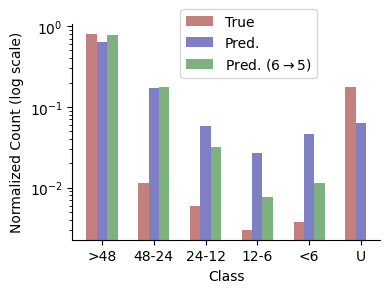

In [8]:

yclass = results['yclass']
logits = results['logits']
class_names = [">48", "48-24", "24-12", "12-6", "<6", "U"]

alpha=0.5
n_classes=logits.shape[-1]
fig, ax=plt.subplots(figsize=(4,3))

# Count true and predicted occurrences per class
true_counts = np.bincount(yclass.long(), minlength=n_classes)
pred_counts = np.bincount(logits.argmax(-1), minlength=n_classes)

x = np.arange(n_classes)  # class indices
width = 0.2  # width of each bar

# Bar plot: side-by-side grouping
ax.bar(x - width, true_counts/logits.shape[0], width=width, alpha=alpha, label="True", color="darkred")
ax.bar(x, pred_counts/logits.shape[0], width=width, alpha=alpha, label="Pred.", color="darkblue")
ax.set_xticks(x, labels=class_names)

n_classes = logits.shape[-1]-1
keep = yclass != n_classes

# Count true and predicted occurrences per class
pred_counts = np.bincount(logits[keep,:-1].argmax(-1), minlength=n_classes)

x = np.arange(n_classes)  # class indices

# Bar plot: side-by-side grouping
ax.bar(x + width, pred_counts/keep.sum(), width=width, alpha=alpha, label="Pred. ($6\\rightarrow 5$)", color="darkgreen")

ax.set_yscale("log")
ax.set_xlabel("Class")
ax.set_ylabel("Normalized Count (log scale)")
ax.legend(loc=(0.35,0.75))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
fig.savefig(os.path.join(output_dir, "val_pred_hist.pdf"),dpi=300)

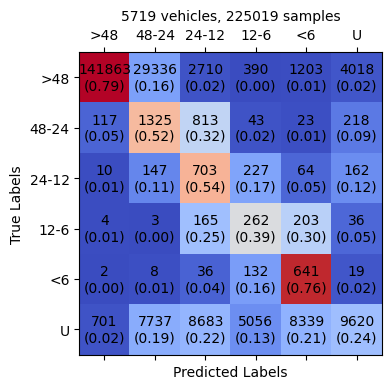

In [9]:
from matplotlib.colors import ListedColormap
white_cmap = ListedColormap(['white'])
title_str = "{} vehicles, {} samples".format(all_results[-1]["fold_val_index"].shape[0], yclass.shape[0])
fig, ax = plt.subplots(figsize=(5,4))
plot_confusion_matrix(ax, yclass, logits.argmax(-1), num_classes=logits.shape[1],class_names=class_names,cmap='coolwarm')
ax.set_title(title_str, fontdict={"size":10})
plt.tight_layout()
fig.savefig(os.path.join(output_dir, "val_confusion_matrix.pdf"), dpi=300)

ValueError: x and y must have same first dimension, but have shapes (61,) and (1,)

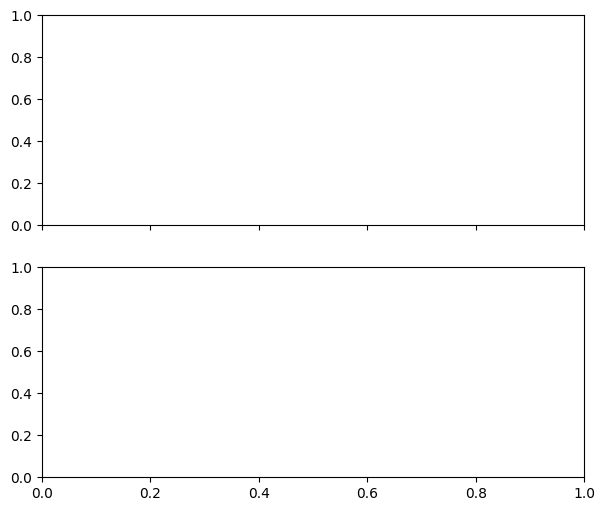

In [10]:
def plot_results(ax,v_id, vdata):
    t_target = vdata["data"]["reference"]
    ax.plot(t_target,results['yclass'][v_id],label="True",color="darkred",marker="*")
    ax.plot(t_target,results['logits'][v_id].argmax(-1),label="Predicted (6 classes)",color="darkblue",marker="x", alpha=0.5)
    ax.plot(t_target,results['logits'][v_id][:,:-1].argmax(-1),label="Predicted (5 classes)",color="darkgreen",marker="d")
    ax.set_yticks(np.arange(6), ltrainer.class_names)
    ax.grid("on")
    ax.set_xlabel("time_step")
    ax.set_ylabel("Class name")
    ax.set_title("v_id={}".format(v_id))
    ax.legend()
    
def plot_timelines(ax,v_id, vdata):
    t_target = vdata["data"]["reference"]
    markersize=6
    all_modalities = [m for m in list(vdata["data"].keys()) if m != "reference"]
    ax.plot(t_target, np.ones(t_target.shape[0]), marker="1", c="darkred",lw=0.5, markersize=markersize)
    for i,m in enumerate(all_modalities):
        timeline = vdata["data"][m][:,-1]
        X = vdata["data"][m][:, :-1]
        ax.plot(timeline, -i*np.ones(timeline.shape[0]), marker="|", c="black",lw=0.5, markersize=markersize)
        ax.set_xlabel("time_step")
        
    ax.set_yticks(ticks=-np.arange(len(all_modalities)+1)+1,labels=["Target"]+all_modalities)  # remove the tick labels
    ax.set_ylabel("Modality name")

v_id = 13
val_set_internal = Subset(dataset, results['fold_val_index'])
for v_id in range(len(results)):
    vdata =  val_set_internal[v_id]
    fig, axes = plt.subplots(2,1,figsize=(7,6),sharex=True)
    ax = axes[0]
    plot_results(ax, v_id, vdata)
    
    ax = axes[1]
    plot_timelines(ax, v_id, vdata)
    fig.savefig(os.path.join(output_dir,"vid{}_timelines.pdf".format(v_id)),dpi=300)
    plt.close(fig)
    if v_id > 100:
        break


In [ ]:
!pdftk results/*timelines.pdf cat output results/timelines_all.pdf